In [6]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


normalizing the data to a standard range, such as [0, 1]

In [4]:
# FashionMNIST images are 28x28 grayscale; ToTensor() -> [0,1]
tfm = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root="./data", train=True,  transform=tfm, download=True)
test_ds  = datasets.FashionMNIST(root="./data", train=False, transform=tfm, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]


In [5]:
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

In [14]:
# Loss Function  BCE because model output uses Sigmoid
loss_fn = nn.BCELoss()
learning_rate = 1e-3
num_epochs = 30
p = 0.3  #drop probability

**Fully Connected AutoEncoder** Encoder: Flatten → 256 → latent(64)

In [8]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)   #encoder
        self.fc2 = nn.Linear(hidden_dim, output_dim)  #decoder
    def forward(self, x):
        out = self.fc1(x) #encoder
        out = F.relu(out) #non-linearity
        out = self.fc2(out) #decoder
        out = torch.sigmoid(out) #Output: [0,1] pixels
        return out

In [9]:
input_dim  = 28*28
hidden_dim = 128
output_dim = input_dim

model = FullyConnectedAutoencoder(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
for epoch in range(1, num_epochs + 1):
    #Train
    model.train()
    tr_sum = tr_n = 0
    for images, _ in train_loader:
        images = images.to(device).view(images.size(0), -1)        # (B,784)
        mask   = (torch.rand_like(images) > p).float()              # Bernoulli mask
        noisy  = images * mask

        optimizer.zero_grad(set_to_none=True)
        out  = model(noisy)
        loss = loss_fn(out, images)
        loss.backward()
        optimizer.step()

        tr_sum += loss.item() * images.size(0)
        tr_n   += images.size(0)
    tr_loss = tr_sum / tr_n

    #Test: report BOTH clean->clean and noisy->clean
    model.eval()
    te_clean_sum = te_denoise_sum = n = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device).view(images.size(0), -1)

            # clean reconstruction
            out_clean = model(images)
            loss_clean = loss_fn(out_clean, images)

            # denoising reconstruction
            mask = (torch.rand_like(images) > p).float()
            noisy = images * mask
            out_noisy = model(noisy)
            loss_denoise = loss_fn(out_noisy, images)

            bs = images.size(0)
            te_clean_sum   += loss_clean.item()   * bs
            te_denoise_sum += loss_denoise.item() * bs
            n += bs

    te_clean   = te_clean_sum / n
    te_denoise = te_denoise_sum / n

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.3f} | test clean loss {te_clean:.3f} | test denoise loss {te_denoise:.3f}")

Epoch 01 | train loss 0.315 | test clean loss 0.321 | test denoise loss 0.307
Epoch 02 | train loss 0.299 | test clean loss 0.329 | test denoise loss 0.297
Epoch 03 | train loss 0.293 | test clean loss 0.336 | test denoise loss 0.293
Epoch 04 | train loss 0.289 | test clean loss 0.335 | test denoise loss 0.290
Epoch 05 | train loss 0.287 | test clean loss 0.327 | test denoise loss 0.288
Epoch 06 | train loss 0.285 | test clean loss 0.329 | test denoise loss 0.287
Epoch 07 | train loss 0.284 | test clean loss 0.330 | test denoise loss 0.286
Epoch 08 | train loss 0.283 | test clean loss 0.333 | test denoise loss 0.285
Epoch 09 | train loss 0.282 | test clean loss 0.325 | test denoise loss 0.284
Epoch 10 | train loss 0.282 | test clean loss 0.332 | test denoise loss 0.284
Epoch 11 | train loss 0.281 | test clean loss 0.327 | test denoise loss 0.283
Epoch 12 | train loss 0.281 | test clean loss 0.327 | test denoise loss 0.283
Epoch 13 | train loss 0.280 | test clean loss 0.327 | test denoi

**CNN-AE**

In [12]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential( # 28x28 -> 14x14 -> 7x7
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),                                #28->14
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),                                # 14->7
        )
        # 7x7 -> 14x14 -> 28x28
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(True),  # 7->14
            nn.ConvTranspose2d(16,  1, 2, stride=2),                 # 14->28
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat
model_cnn = CNNAutoencoder().to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

In [13]:
for epoch in range(1, num_epochs + 1):
    #train (noisy -> clean)
    model_cnn.train()
    tr_sum = tr_n = 0
    for images, _ in train_loader:
        images = images.to(device)                           # (B,1,28,28)
        mask   = (torch.rand_like(images) > p).float()
        noisy  = images * mask

        optimizer.zero_grad()
        out  = model_cnn(noisy)
        loss = loss_fn(out, images)
        loss.backward()
        optimizer.step()

        tr_sum += loss.item() * images.size(0); tr_n += images.size(0)
    tr_loss = tr_sum / tr_n

    #test (clean)
    model_cnn.eval()
    te_sum = te_n = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            out  = model_cnn(images)
            loss = loss_fn(out, images)
            te_sum += loss.item() * images.size(0); te_n += images.size(0)
    te_loss = te_sum / te_n

    print(f"[CNN-AE] Epoch {epoch:02d} | train {tr_loss:.4f} | test {te_loss:.4f}")

[CNN-AE] Epoch 01 | train 0.4041 | test 0.3075
[CNN-AE] Epoch 02 | train 0.2943 | test 0.2899
[CNN-AE] Epoch 03 | train 0.2854 | test 0.2834
[CNN-AE] Epoch 04 | train 0.2809 | test 0.2803
[CNN-AE] Epoch 05 | train 0.2785 | test 0.2781
[CNN-AE] Epoch 06 | train 0.2769 | test 0.2766
[CNN-AE] Epoch 07 | train 0.2757 | test 0.2756
[CNN-AE] Epoch 08 | train 0.2748 | test 0.2746
[CNN-AE] Epoch 09 | train 0.2740 | test 0.2739
[CNN-AE] Epoch 10 | train 0.2733 | test 0.2733
[CNN-AE] Epoch 11 | train 0.2728 | test 0.2728
[CNN-AE] Epoch 12 | train 0.2723 | test 0.2721
[CNN-AE] Epoch 13 | train 0.2718 | test 0.2717
[CNN-AE] Epoch 14 | train 0.2714 | test 0.2712
[CNN-AE] Epoch 15 | train 0.2710 | test 0.2707
[CNN-AE] Epoch 16 | train 0.2707 | test 0.2703
[CNN-AE] Epoch 17 | train 0.2704 | test 0.2701
[CNN-AE] Epoch 18 | train 0.2701 | test 0.2696
[CNN-AE] Epoch 19 | train 0.2698 | test 0.2695
[CNN-AE] Epoch 20 | train 0.2696 | test 0.2691
[CNN-AE] Epoch 21 | train 0.2694 | test 0.2692
[CNN-AE] Epoc

**Sparse AE**

In [16]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=128, output_dim=28*28, l1_lambda=1e-3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.l1_lambda = l1_lambda
    def forward(self, x):
        h   = F.relu(self.fc1(x))      # latent
        out = torch.sigmoid(self.fc2(h))
        return out, h

model_sparse = SparseAutoencoder(l1_lambda=1e-3).to(device)
optimizer = torch.optim.Adam(model_sparse.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    model_sparse.train()
    tr_sum = tr_n = 0
    for images, _ in train_loader:
        images = images.to(device).view(images.size(0), -1)
        mask   = (torch.rand_like(images) > p).float()
        noisy  = images * mask

        optimizer.zero_grad()
        out, h = model_sparse(noisy)
        loss = loss_fn(out, images) + model_sparse.l1_lambda * h.abs().mean()
        loss.backward()
        optimizer.step()

        tr_sum += loss.item() * images.size(0); tr_n += images.size(0)
    tr_loss = tr_sum / tr_n

    model_sparse.eval()
    te_sum = te_n = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device).view(images.size(0), -1)
            out, _ = model_sparse(images)
            loss = loss_fn(out, images)
            te_sum += loss.item() * images.size(0); te_n += images.size(0)
    te_loss = te_sum / te_n

    print(f"[Sparse-AE] Epoch {epoch:02d} | train {tr_loss:.3f} | test {te_loss:.3f}")


[Sparse-AE] Epoch 01 | train 0.391 | test 0.335
[Sparse-AE] Epoch 02 | train 0.318 | test 0.324
[Sparse-AE] Epoch 03 | train 0.301 | test 0.330
[Sparse-AE] Epoch 04 | train 0.294 | test 0.338
[Sparse-AE] Epoch 05 | train 0.291 | test 0.330
[Sparse-AE] Epoch 06 | train 0.288 | test 0.327
[Sparse-AE] Epoch 07 | train 0.287 | test 0.333
[Sparse-AE] Epoch 08 | train 0.285 | test 0.330
[Sparse-AE] Epoch 09 | train 0.284 | test 0.336
[Sparse-AE] Epoch 10 | train 0.284 | test 0.343
[Sparse-AE] Epoch 11 | train 0.283 | test 0.331
[Sparse-AE] Epoch 12 | train 0.282 | test 0.328
[Sparse-AE] Epoch 13 | train 0.282 | test 0.325
[Sparse-AE] Epoch 14 | train 0.281 | test 0.333
[Sparse-AE] Epoch 15 | train 0.281 | test 0.331
[Sparse-AE] Epoch 16 | train 0.280 | test 0.322
[Sparse-AE] Epoch 17 | train 0.280 | test 0.326
[Sparse-AE] Epoch 18 | train 0.280 | test 0.324
[Sparse-AE] Epoch 19 | train 0.280 | test 0.323
[Sparse-AE] Epoch 20 | train 0.279 | test 0.323
[Sparse-AE] Epoch 21 | train 0.279 | tes

**RNN- AE**

In [17]:
class RNNAutoencoder(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.enc = nn.LSTM(input_size=28, hidden_size=hidden, batch_first=True)
        self.dec = nn.LSTM(input_size=28, hidden_size=hidden, batch_first=True)
        self.out = nn.Linear(hidden, 28)
    def forward(self, x_seq):
        # x_seq: (B,28,28)
        _, (h, c) = self.enc(x_seq)             # h: (1,B,H)
        dec_h, dec_c = h, torch.zeros_like(h)   # init decoder state
        dec_in = torch.zeros_like(x_seq)        # teacher-forcing zeros
        y, _ = self.dec(dec_in, (dec_h, dec_c)) # (B,28,H)
        x_hat = torch.sigmoid(self.out(y)).unsqueeze(1)  # (B,1,28,28)
        return x_hat

model_rnn = RNNAutoencoder(hidden=128).to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    model_rnn.train()
    tr_sum = tr_n = 0
    for images, _ in train_loader:
        images = images.to(device)                  # (B,1,28,28)
        seq    = images.squeeze(1)                  # (B,28,28)
        mask   = (torch.rand_like(seq) > p).float()
        noisy  = seq * mask

        optimizer.zero_grad()
        out  = model_rnn(noisy)                     # (B,1,28,28)
        loss = loss_fn(out, images)
        loss.backward()
        optimizer.step()

        tr_sum += loss.item() * images.size(0); tr_n += images.size(0)
    tr_loss = tr_sum / tr_n

    model_rnn.eval()
    te_sum = te_n = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            seq    = images.squeeze(1)
            out  = model_rnn(seq)
            loss = loss_fn(out, images)
            te_sum += loss.item() * images.size(0); te_n += images.size(0)
    te_loss = te_sum / te_n

    print(f"[RNN-AE] Epoch {epoch:02d} | train {tr_loss:.3f} | test {te_loss:.3f}")


[RNN-AE] Epoch 01 | train 0.519 | test 0.493
[RNN-AE] Epoch 02 | train 0.456 | test 0.402
[RNN-AE] Epoch 03 | train 0.360 | test 0.385
[RNN-AE] Epoch 04 | train 0.341 | test 0.366
[RNN-AE] Epoch 05 | train 0.328 | test 0.371
[RNN-AE] Epoch 06 | train 0.318 | test 0.355
[RNN-AE] Epoch 07 | train 0.313 | test 0.358
[RNN-AE] Epoch 08 | train 0.309 | test 0.353
[RNN-AE] Epoch 09 | train 0.307 | test 0.349
[RNN-AE] Epoch 10 | train 0.305 | test 0.357
[RNN-AE] Epoch 11 | train 0.303 | test 0.352
[RNN-AE] Epoch 12 | train 0.302 | test 0.352
[RNN-AE] Epoch 13 | train 0.300 | test 0.351
[RNN-AE] Epoch 14 | train 0.299 | test 0.356
[RNN-AE] Epoch 15 | train 0.297 | test 0.350
[RNN-AE] Epoch 16 | train 0.296 | test 0.347
[RNN-AE] Epoch 17 | train 0.295 | test 0.347
[RNN-AE] Epoch 18 | train 0.294 | test 0.336
[RNN-AE] Epoch 19 | train 0.293 | test 0.347
[RNN-AE] Epoch 20 | train 0.292 | test 0.344
[RNN-AE] Epoch 21 | train 0.292 | test 0.350
[RNN-AE] Epoch 22 | train 0.291 | test 0.341
[RNN-AE] E

**Variational (VAE)**

In [18]:
class VAE(nn.Module):
    def __init__(self, latent=2):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc_mu = nn.Linear(256, latent)
        self.fc_logvar = nn.Linear(256, latent)
        self.fc3 = nn.Linear(latent, 256)
        self.fc4 = nn.Linear(256, 28*28)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    def forward(self, x_flat):
        mu, logvar = self.encode(x_flat)
        z = self.reparam(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

model_vae = VAE(latent=2).to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    # Train
    model_vae.train()
    tr_sum = tr_n = 0
    for images, _ in train_loader:
        images = images.to(device).view(images.size(0), -1)  # (B,784)
        optimizer.zero_grad()
        x_hat, mu, logvar = model_vae(images)
        recon = torch.nn.functional.binary_cross_entropy(x_hat, images, reduction="sum")
        kld   = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss  = (recon + kld) / images.size(0)               # average per batch
        loss.backward()
        optimizer.step()
        tr_sum += loss.item() * images.size(0); tr_n += images.size(0)
    tr_loss = tr_sum / tr_n

    # test
    model_vae.eval()
    te_sum = te_n = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device).view(images.size(0), -1)
            x_hat, mu, logvar = model_vae(images)
            recon = torch.nn.functional.binary_cross_entropy(x_hat, images, reduction="sum")
            kld   = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss  = (recon + kld) / images.size(0)
            te_sum += loss.item() * images.size(0); te_n += images.size(0)
    te_loss = te_sum / te_n

    print(f"[VAE] Epoch {epoch:02d} | train {tr_loss:.3f} | test {te_loss:.3f}")


[VAE] Epoch 01 | train 312.532 | test 283.833
[VAE] Epoch 02 | train 279.259 | test 278.807
[VAE] Epoch 03 | train 274.793 | test 274.452
[VAE] Epoch 04 | train 272.230 | test 272.666
[VAE] Epoch 05 | train 270.701 | test 271.790
[VAE] Epoch 06 | train 269.420 | test 270.202
[VAE] Epoch 07 | train 268.514 | test 269.198
[VAE] Epoch 08 | train 267.603 | test 268.695
[VAE] Epoch 09 | train 266.833 | test 267.650
[VAE] Epoch 10 | train 266.265 | test 267.476
[VAE] Epoch 11 | train 265.651 | test 266.754
[VAE] Epoch 12 | train 265.272 | test 266.787
[VAE] Epoch 13 | train 264.789 | test 266.358
[VAE] Epoch 14 | train 264.517 | test 266.040
[VAE] Epoch 15 | train 264.182 | test 265.506
[VAE] Epoch 16 | train 263.910 | test 265.898
[VAE] Epoch 17 | train 263.690 | test 265.246
[VAE] Epoch 18 | train 263.422 | test 265.282
[VAE] Epoch 19 | train 263.226 | test 264.833
[VAE] Epoch 20 | train 263.002 | test 264.508
[VAE] Epoch 21 | train 262.823 | test 264.557
[VAE] Epoch 22 | train 262.615 | t

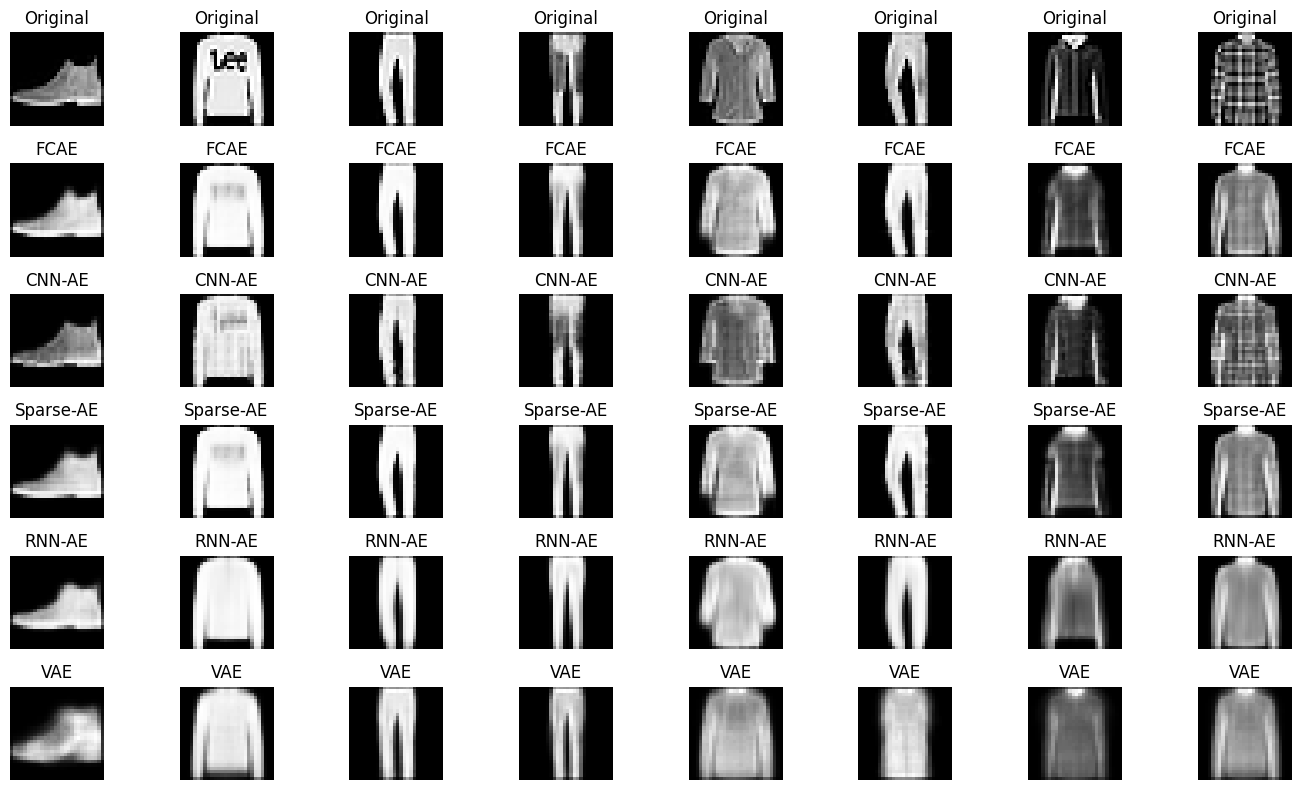

In [19]:
import matplotlib.pyplot as plt

#small batch
model.eval()
model_cnn.eval()
model_sparse.eval()
model_rnn.eval()
model_vae.eval()

with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images[:8].to(device)  # 8 samples
    flat   = images.view(images.size(0), -1)

    rec_fcae   = model(flat).view(-1,1,28,28).cpu()
    rec_cnn    = model_cnn(images).cpu()
    rec_sparse = model_sparse(flat)[0].view(-1,1,28,28).cpu()
    rec_rnn    = model_rnn(images.squeeze(1)).cpu()
    rec_vae    = model_vae(flat)[0].view(-1,1,28,28).cpu()

orig = images.cpu()

titles = ["Original", "FCAE", "CNN-AE", "Sparse-AE", "RNN-AE", "VAE"]
rows = 2
cols = 8
fig, axs = plt.subplots(len(titles), 8, figsize=(14, 8))
for i in range(8):
    axs[0, i].imshow(orig[i,0], cmap='gray'); axs[0, i].axis('off'); axs[0, i].set_title(titles[0])
    axs[1, i].imshow(rec_fcae[i,0], cmap='gray'); axs[1, i].axis('off'); axs[1, i].set_title(titles[1])
    axs[2, i].imshow(rec_cnn[i,0], cmap='gray'); axs[2, i].axis('off'); axs[2, i].set_title(titles[2])
    axs[3, i].imshow(rec_sparse[i,0], cmap='gray'); axs[3, i].axis('off'); axs[3, i].set_title(titles[3])
    axs[4, i].imshow(rec_rnn[i,0], cmap='gray'); axs[4, i].axis('off'); axs[4, i].set_title(titles[4])
    axs[5, i].imshow(rec_vae[i,0], cmap='gray'); axs[5, i].axis('off'); axs[5, i].set_title(titles[5])

plt.tight_layout(); plt.show()
